# Using a constraints file 

One of the advantages of using integer programming (or indeed any sort of constraint programming) for machine learning is that it is relatively easy to add user constraints to ensure that what is learned is consistent with known information. There are a number of ways of doing this with PyGobnilp. In this notebook we show how to declare constraints by putting them in a file. This method is particularly useful when running Gobnilp as a script from the command line, but here we will demonstrate how it works using an interactive session.

We will first of all do some 'vanilla' learning where we just learn an optimal BN from some discrete data.

Using license file /home/james/gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
**********
BN has score -24028.0947783535
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.014444236549
E<-B,F -4310.304956470649
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A][B|A][C][D|A:C][E|F:B][F]
**********
CPD

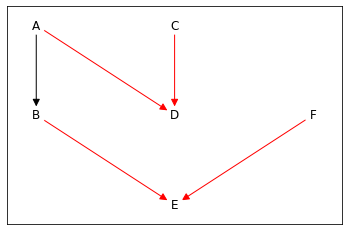

In [1]:
from pygobnilp.gobnilp import Gobnilp
m = Gobnilp()
m.learn('discrete.dat',palim=None)

In the learned network A and B are both ancestors of E. Suppose we wanted to learn the optimal (highest-scoring) network *subject to the condition that both A and B are not ancestors of E*. One way to do this is to put this constraint in a constraints file. A constraints file must be a Python module which defines functions effecting the constraints. For our current example, we need to provide an appropriate definition for the function `forbidden_ancestors`.

Suppose we created a Python module called `cons1.py` which just contained the following definition:

```
def forbidden_ancestors(gobnilp):
    return [('A','E'),('B','E')]
```

Then we can do this:

Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
**********
BN has score -24035.844609079217
**********
A<-B -4349.791324894952
B<-E,F -4134.331340440418
E<- -5468.229676086663
F<-E -3026.9672848237205
C<- -3501.5105385969146
D<-A,C -3555.014444236549
**********
bnlearn modelstring = 
[A|B][B|E:F][E][F|E][C][D|A:C]
**********
CPDAG:
Vertices: A,B,E,F,C,D
A->D
B-A
E-B
E-F
F-B
C->D



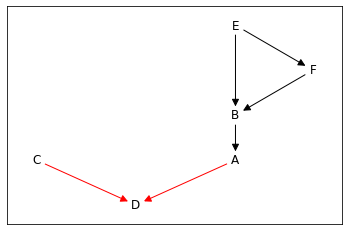

In [2]:
m = Gobnilp()
m.learn('discrete.dat',palim=None,consfile='cons1')

Notice that this time, neither A nor B are ancestors of E. In fact E is a source node with no parents. Note also that the score of this second network is lower than the first due to these constraints.

A `forbidden_ancestors` function is expected to return a list of pairs of forbidden ancestor relations (with the forbidden ancestor the first element of the pair and the forbidden descendent the second element). A user can also provide definitions for the following functions in the same way:

* `forbidden_arrows`
* `forbidden_adjacencies`
* `obligatory_arrows`
* `obligatory_adjacencies`
* `obligatory_ancestors`
* `obligatory_conditional_independences`

Note that the function is called with a single argument. This will be the current `Gobnilp` object. This allows the user access, for example, to the set of BN variables. So to require that all variables are parents of, say, E, we can put the following definition in a constraints file:

```
def obligatory_arrows(gobnilp):
    return ([(v,'E') for v in gobnilp.bn_variables if v != 'E'])
```

Suppose that definition were in a file called `cons2.py` then we can do this:

Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
**********
BN has score -25116.974592860606
**********
A<-B -4349.791324894952
B<- -4841.285573475907
C<- -3501.5105385969146
D<-A,C -3555.014444236549
E<-A,B,C,D,F -5399.184770977754
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A|B][B][C][D|A:C][E|F:C:D:A:B][F]
**********
CPDAG:
Vertices: A,B,C,D,E,F
A->D
A->E
B-A
B->E
C->D
C->E
D->E
F->E



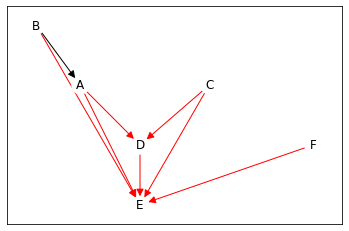

{('A', 'E'), ('B', 'E'), ('C', 'E'), ('D', 'E'), ('F', 'E')}

In [3]:
m = Gobnilp()
m.learn('discrete.dat',palim=None,pruning=False,consfile='cons2')
m.obligatory_arrows

Sure enough a BN where all other nodes are parents of E is created. The BN learned is an optimal one subject to these constraints.

A more complex constraint is to make certain conditional independence relations obligatory. Note that without any constraints we end up with a network where A is **not** independent of C given D. Suppose we wanted to find an optimal network subject to the constraints that A was independent of C given D. We can do this by putting the following function in a constraints file.

```
def obligatory_conditional_independences(gobnilp):
    return [(['A'],['C'],['D'])]
```

Suppose that definition were in a file called `cons3.py`. Then we can do:

Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
**********
BN has score -24832.81475418423
**********
A<-D -4376.2801910701055
D<- -5496.966762872751
B<-A -3688.9395212202216
C<-D -3490.1353818719726
E<-B,F -4310.304956470649
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A|D][D][B|A][C|D][E|F:B][F]
**********
CPDAG:
Vertices: A,D,B,C,E,F
A-B
D-A
D-C
B->E
F->E



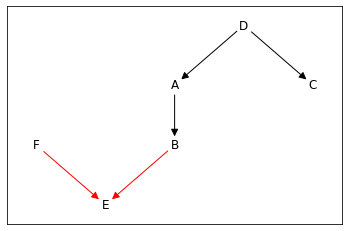

Forbidden arrows {('C', 'A'), ('A', 'C')}
Forbidden adjacencies {frozenset({'A', 'C'})}
Obligatory conditional independences {(frozenset({'A'}), frozenset({'C'}), frozenset({'D'}))}


In [4]:
m = Gobnilp()
m.learn('discrete.dat',palim=None,pruning=False,consfile='cons3')
print('Forbidden arrows', m.forbidden_arrows)
print('Forbidden adjacencies', m.forbidden_adjacencies)
print('Obligatory conditional independences', m.obligatory_conditional_independences)

In this BN, A and C are indeed independent given D.